# Summary:
1. Fit 3 binary classifiers to predict churn label- logistic regression, random forest and gradient boosting tree.
2. Evaluate the model performance with ROC curve and Spark built-in evaluator. The best performing model is Random forest(0.94 AUC), second is GBT(0.939 AUC), though the difference of auc is very tiny among 3 models.
3. Use Grid search to fine tune the two tree models and compared the lift between the optimized models and default setting models.
4. Explore the feature importances of prediction. Play related features dominate the top 10 most importance features from both random forest and gradient boosting tree models.

In [1]:
from pyspark.sql.types import *
from pyspark.mllib.linalg import Vectors
from pyspark.mllib.linalg import DenseVector
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.feature import StringIndexer, VectorIndexer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import BinaryClassificationEvaluator
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np 
import seaborn as sns
from pyspark.sql import SparkSession

In [2]:
spark = SparkSession.builder.appName("Music Box model build").getOrCreate()
df = spark.read.csv('./intermediate tables/all_features_label_combined.csv',header=True,inferSchema=True).cache()

In [3]:
pd.DataFrame(df.take(5),columns=df.columns)

,_c0,uid,play_times_last_3_days,play_times_last_7_days,play_times_last_14_days,play_times_last_21_days,play_times_last_30_days,avg_playtime_last_3_days,avg_playtime_last_7_days,avg_playtime_last_14_days,...,download_times_last_21_days,download_times_last_30_days,days_since_last_download,search_times_last_3_days,search_times_last_7_days,search_times_last_14_days,search_times_last_21_days,search_times_last_30_days,days_since_last_search,Churn
0,0,114363528.0,0,0,0,1,20,0.000000,0.000000,0.000000,...,6,14,12,0,0,0,0,8,30,1
1,1,167920832.0,9,22,354,560,817,517.333333,484.571429,4783.285714,...,2,7,12,0,1,3,12,29,7,0
2,2,168573152.0,0,0,0,0,109,0.000000,0.000000,0.000000,...,0,0,0,0,0,0,0,12,30,1
3,3,57077508.0,216,372,1020,1510,2388,8823.000000,7222.714286,9382.285714,...,4,4,13,0,4,13,20,21,5,0
4,4,157815664.0,0,81,182,184,233,0.000000,2289.000000,2337.071429,...,0,2,23,0,0,0,0,2,23,1


In [4]:
df=df.drop('_c0')
df.count()

105351

In [5]:
df.columns

['uid',
 'play_times_last_3_days',
 'play_times_last_7_days',
 'play_times_last_14_days',
 'play_times_last_21_days',
 'play_times_last_30_days',
 'avg_playtime_last_3_days',
 'avg_playtime_last_7_days',
 'avg_playtime_last_14_days',
 'avg_playtime_last_21_days',
 'avg_playtime_last_30_days',
 'days_since_last_play',
 'download_times_last_3_days',
 'download_times_last_7_days',
 'download_times_last_14_days',
 'download_times_last_21_days',
 'download_times_last_30_days',
 'days_since_last_download',
 'search_times_last_3_days',
 'search_times_last_7_days',
 'search_times_last_14_days',
 'search_times_last_21_days',
 'search_times_last_30_days',
 'days_since_last_search',
 'Churn']

In [6]:
# churn label percentage in the dataset
label=df.select('Churn').toPandas()
label.Churn.value_counts()/label.shape[0]

0    0.844852
1    0.155148
Name: Churn, dtype: float64

### 1.1 Prep the features for model

In [7]:
features=df.columns
features.remove('uid')
features.remove('Churn')
features

['play_times_last_3_days',
 'play_times_last_7_days',
 'play_times_last_14_days',
 'play_times_last_21_days',
 'play_times_last_30_days',
 'avg_playtime_last_3_days',
 'avg_playtime_last_7_days',
 'avg_playtime_last_14_days',
 'avg_playtime_last_21_days',
 'avg_playtime_last_30_days',
 'days_since_last_play',
 'download_times_last_3_days',
 'download_times_last_7_days',
 'download_times_last_14_days',
 'download_times_last_21_days',
 'download_times_last_30_days',
 'days_since_last_download',
 'search_times_last_3_days',
 'search_times_last_7_days',
 'search_times_last_14_days',
 'search_times_last_21_days',
 'search_times_last_30_days',
 'days_since_last_search']

In [8]:
# training data
assembler = VectorAssembler(
    inputCols=features,
    outputCol="features")
data = assembler.transform(df)
#selected_data=data.select('features','Churn')
# train test split
(train, test) = data.randomSplit([0.7, 0.3], seed=1)

In [9]:
train.show(2)

+--------+----------------------+----------------------+-----------------------+-----------------------+-----------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+--------------------+--------------------------+--------------------------+---------------------------+---------------------------+---------------------------+------------------------+------------------------+------------------------+-------------------------+-------------------------+-------------------------+----------------------+-----+--------------------+
|     uid|play_times_last_3_days|play_times_last_7_days|play_times_last_14_days|play_times_last_21_days|play_times_last_30_days|avg_playtime_last_3_days|avg_playtime_last_7_days|avg_playtime_last_14_days|avg_playtime_last_21_days|avg_playtime_last_30_days|days_since_last_play|download_times_last_3_days|download_times_last_7_days|download_times_last_14_days|download_times_last_21

### 2.1 Fit Logistic regression model

In [31]:
# Create initial LogisticRegression model
lr = LogisticRegression(labelCol="Churn", featuresCol="features", maxIter=10)

# Train model with Training Data
lrModel = lr.fit(train)

In [37]:
# Predict train data
lr_pred_train = lrModel.transform(train)
lr_pred_train.printSchema()

root
 |-- uid: double (nullable = true)
 |-- play_times_last_3_days: integer (nullable = true)
 |-- play_times_last_7_days: integer (nullable = true)
 |-- play_times_last_14_days: integer (nullable = true)
 |-- play_times_last_21_days: integer (nullable = true)
 |-- play_times_last_30_days: integer (nullable = true)
 |-- avg_playtime_last_3_days: double (nullable = true)
 |-- avg_playtime_last_7_days: double (nullable = true)
 |-- avg_playtime_last_14_days: double (nullable = true)
 |-- avg_playtime_last_21_days: double (nullable = true)
 |-- avg_playtime_last_30_days: double (nullable = true)
 |-- days_since_last_play: integer (nullable = true)
 |-- download_times_last_3_days: integer (nullable = true)
 |-- download_times_last_7_days: integer (nullable = true)
 |-- download_times_last_14_days: integer (nullable = true)
 |-- download_times_last_21_days: integer (nullable = true)
 |-- download_times_last_30_days: integer (nullable = true)
 |-- days_since_last_download: integer (nullable

In [33]:
# Select example rows to display.
lr_pred_train.select("probability","rawPrediction","prediction", "Churn", "features").show(5)
eval_lr_train = lr_pred_train.select("probability", "Churn").toPandas()


# Predict test data
lr_pred_test = lrModel.transform(test)

# Select example rows to display.
lr_pred_test.select("probability","rawPrediction","prediction", "Churn", "features").show(5)
eval_lr_test = lr_pred_test.select("probability", "Churn").toPandas()


+--------------------+--------------------+----------+-----+--------------------+
|         probability|       rawPrediction|prediction|Churn|            features|
+--------------------+--------------------+----------+-----+--------------------+
|[0.88719266728825...|[2.06238082773685...|       0.0|    0|(23,[0,1,2,3,4,5,...|
|[0.32558898420820...|[-0.7282039394934...|       1.0|    0|(23,[3,4,8,9,10],...|
|[0.99746733090247...|[5.97594567135247...|       0.0|    0|[61.0,372.0,898.0...|
|[0.18412293134533...|[-1.4886600527927...|       1.0|    1|(23,[4,9,10,15,16...|
|[0.85904623578661...|[1.80739082244305...|       0.0|    0|[6.0,13.0,20.0,35...|
+--------------------+--------------------+----------+-----+--------------------+
only showing top 5 rows

+--------------------+--------------------+----------+-----+--------------------+
|         probability|       rawPrediction|prediction|Churn|            features|
+--------------------+--------------------+----------+-----+-------------

### 2.2 Evaluate the model performance with ROC curve

In [27]:
%matplotlib inline
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc, roc_auc_score
# define a generic roc plot function
def plot_roc_curve(model,y_train, y_train_pred, y_test, y_test_pred):
    roc_auc_train = roc_auc_score(y_train, y_train_pred)
    fpr_train, tpr_train, threshold = roc_curve(y_train, y_train_pred)

    roc_auc_test = roc_auc_score(y_test, y_test_pred)
    fpr_test, tpr_test, threshold = roc_curve(y_test, y_test_pred)
    plt.figure()
    lw = 2
    plt.plot(fpr_train, tpr_train, color='green',
             lw=lw, label='ROC Train (AUC = %0.4f)' % roc_auc_train)
    plt.plot(fpr_test, tpr_test, color='darkorange',
             lw=lw, label='ROC Test (AUC = %0.4f)' % roc_auc_test)
    plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC curve for '+ model)
    plt.legend(loc="lower right")
    plt.show()
    

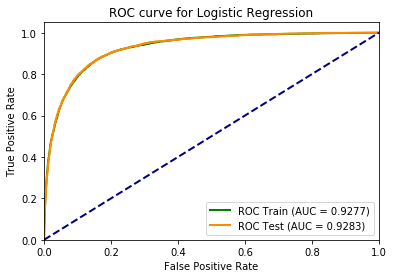

In [44]:
y_train = eval_lr_train['Churn']
y_train_pred = [v[1] for v in eval_lr_train['probability']]
y_test = eval_lr_test['Churn']
y_test_pred = [v[1] for v in eval_lr_test['probability']]

plot_roc_curve('Logistic Regression', y_train, y_train_pred, y_test, y_test_pred)

In [50]:
#print(lr.explainParams())

In [48]:
# Evaluate model with SparkML evaluator. default metric for binary classifier is "areaUnderROC"
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol='Churn')
evaluator.evaluate(lr_pred_test)
#number matches sklearn auc precisely

0.9282706530505878

### 3.1 Fit Random Forest model

In [51]:
# Create an initial RandomForest model.
rf = RandomForestClassifier(labelCol="Churn", featuresCol="features")

# Train model with Training Data
rfModel = rf.fit(train)

In [53]:
# Predict test data with default parameters
rf_pred_test_org = rfModel.transform(test)

#evaluate the untuned model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol='Churn')
evaluator.evaluate(rf_pred_test_org)

0.9388142387482282

### 3.2 Use Spark Grid Search and Cross Validator to fine tune the RF parameters

In [56]:
# Create ParamGrid for Cross Validation
from pyspark.ml.tuning import ParamGridBuilder, CrossValidator

paramGrid = (ParamGridBuilder()
             .addGrid(rf.maxDepth, [4, 7, 10])#default 5
             .addGrid(rf.maxBins, [30, 60]) #default 32
             .addGrid(rf.numTrees, [20, 30, 40]) #default 20
             .addGrid(rf.subsamplingRate,[0.8,1.0])#default 1.0
             .build())

In [58]:
# Create 5-fold CrossValidator with Spark Grid Search
cv = CrossValidator(estimator=rf, estimatorParamMaps=paramGrid, evaluator=evaluator, numFolds=5)

# Run cross validations. time how long it takes for training to finish
import time
start_time = time.time()

rf_cvModel = cv.fit(train)

print("Training took {0} seconds.".format(time.time() - start_time))

Exception ignored in: <object repr() failed>
Traceback (most recent call last):
  File "/Users/lalago31/anaconda3/lib/python3.6/site-packages/pyspark/ml/wrapper.py", line 105, in __del__
    SparkContext._active_spark_context._gateway.detach(self._java_obj)
AttributeError: 'BinaryClassificationEvaluator' object has no attribute '_java_obj'


Training took 387.3703520298004 seconds.


In [73]:
print('The best set of parameters of RF model is: \n' + str(rf_cvModel.getEstimatorParamMaps()[np.argmax(rf_cvModel.avgMetrics)]))

The best set of parameters of RF model is: 
{Param(parent='RandomForestClassifier_4352b1af85533938087c', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 10, Param(parent='RandomForestClassifier_4352b1af85533938087c', name='maxBins', doc='Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature.'): 60, Param(parent='RandomForestClassifier_4352b1af85533938087c', name='numTrees', doc='Number of trees to train (>= 1).'): 40, Param(parent='RandomForestClassifier_4352b1af85533938087c', name='subsamplingRate', doc='Fraction of the training data used for learning each decision tree, in range (0, 1].'): 1.0}


In [74]:
rf_bestModel = rf_cvModel.bestModel
# use the best set of params to predict on train and test
rf_pred_train_best = rf_bestModel.transform(train)
rf_pred_test_best = rf_bestModel.transform(test)

eval_rf_train = rf_pred_train_best.select("probability", "Churn").toPandas()
eval_rf_test = rf_pred_test_best.select("probability", "Churn").toPandas()

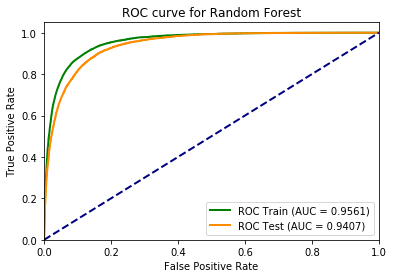

In [75]:
y_train = eval_rf_train['Churn']
y_train_pred = [v[1] for v in eval_rf_train['probability']]
y_test = eval_rf_test['Churn']
y_test_pred = [v[1] for v in eval_rf_test['probability']]

plot_roc_curve('Random Forest', y_train, y_train_pred, y_test, y_test_pred)

#### How much improvement of model performance is gained from fine-tuning of parameters?

In [78]:
untuned_auc = evaluator.evaluate(rf_pred_test_org)
tuned_auc = evaluator.evaluate(rf_pred_test_best)
print('Fine tuning model parameters improved AUC by {}'.format(tuned_auc-untuned_auc))

Fine tuning model parameters improved AUC by 0.0018863971116211964


In [96]:
evaluator.setMetricName("areaUnderPR")
untuned_pr = evaluator.evaluate(rf_pred_test_org)
tuned_pr = evaluator.evaluate(rf_pred_test_best)
print('Fine tuning model parameters improved area under precision-recall curve by {}'.format(tuned_pr-untuned_pr))

Fine tuning model parameters improved area under precision-recall curve by 0.008083562370346242


### 3.3 Understand the feature importances 

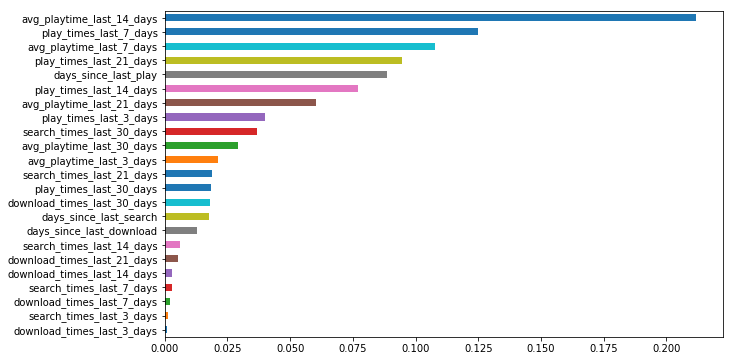

In [112]:
feature_importance = pd.Series(rf_bestModel.featureImportances.toArray(), index=pd.Series(features)).sort_values()
fig = plt.figure(figsize = (10,6))
feature_importance.plot.barh()
#plt.xticks

* Play features dominate the top 10 most important features. This is consistent with what is shown in the EDA- these is a clear correlation between play and download/search activities. The more user download or search, the more they play, and vice versa.

### 4.1 Fit Gradient Boosting Tree model

In [10]:
# Create an initial GBT model.
gbt = GBTClassifier(labelCol="Churn", featuresCol="features")

# Train model with Training Data
gbtModel = gbt.fit(train)

# Predict test data with default parameters
gbt_pred_test_org = gbtModel.transform(test)

#evaluate the untuned model
evaluator = BinaryClassificationEvaluator(rawPredictionCol="rawPrediction",labelCol='Churn')
evaluator.evaluate(gbt_pred_test_org)

0.9395156929989442

In [11]:
print(gbt.explainParams())

cacheNodeIds: If false, the algorithm will pass trees to executors to match instances with nodes. If true, the algorithm will cache node IDs for each instance. Caching can speed up training of deeper trees. Users can set how often should the cache be checkpointed or disable it by setting checkpointInterval. (default: False)
checkpointInterval: set checkpoint interval (>= 1) or disable checkpoint (-1). E.g. 10 means that the cache will get checkpointed every 10 iterations. Note: this setting will be ignored if the checkpoint directory is not set in the SparkContext. (default: 10)
featuresCol: features column name. (default: features, current: features)
labelCol: label column name. (default: label, current: Churn)
lossType: Loss function which GBT tries to minimize (case-insensitive). Supported options: logistic (default: logistic)
maxBins: Max number of bins for discretizing continuous features.  Must be >=2 and >= number of categories for any categorical feature. (default: 32)
maxDepth

### 4.2 Fine Tuning GBT Parameters

In [12]:
paramGrid = ParamGridBuilder()\
  .addGrid(gbt.maxDepth, [5,10])\
  .addGrid(gbt.maxIter, [10, 20])\
  .addGrid(gbt.stepSize, [0.05, 0.1])\
  .build()
# Define an evaluation metric.  This tells CrossValidator how well we are doing by comparing the true labels with predictions.
evaluator = BinaryClassificationEvaluator(metricName="areaUnderROC", labelCol=gbt.getLabelCol())
# intitiate the cross validator
cv = CrossValidator(estimator=gbt, evaluator=evaluator, estimatorParamMaps=paramGrid)

In [14]:
#train gbt model with cv
import time
start_time =time.time()
gbt_cvModel=cv.fit(train)
print('training GBT took {0}'.format(time.time() - start_time))

training GBT took 192.2583029270172


In [15]:
print('The best set of parameters of GBT model is: \n' + str(gbt_cvModel.getEstimatorParamMaps()[np.argmax(gbt_cvModel.avgMetrics)]))

The best set of parameters of GBT model is: 
{Param(parent='GBTClassifier_4d2e8312c5ec8267ffeb', name='maxDepth', doc='Maximum depth of the tree. (>= 0) E.g., depth 0 means 1 leaf node; depth 1 means 1 internal node + 2 leaf nodes.'): 5, Param(parent='GBTClassifier_4d2e8312c5ec8267ffeb', name='maxIter', doc='max number of iterations (>= 0).'): 20, Param(parent='GBTClassifier_4d2e8312c5ec8267ffeb', name='stepSize', doc='Step size (a.k.a. learning rate) in interval (0, 1] for shrinking the contribution of each estimator.'): 0.1}


In [25]:
gbt_bestModel = gbt_cvModel.bestModel
# use the best set of params to predict on train and test
gbt_pred_train_best = gbt_cvModel.transform(train)
gbt_pred_test_best = gbt_cvModel.transform(test)

eval_gbt_train = gbt_pred_train_best.select("probability", "Churn").toPandas()
eval_gbt_test = gbt_pred_test_best.select("probability", "Churn").toPandas()

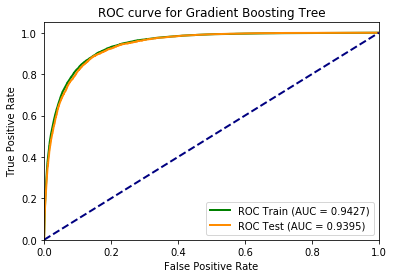

In [28]:
y_train = eval_gbt_train['Churn']
y_train_pred = [v[1] for v in eval_gbt_train['probability']]
y_test = eval_gbt_test['Churn']
y_test_pred = [v[1] for v in eval_gbt_test['probability']]

plot_roc_curve('Gradient Boosting Tree', y_train, y_train_pred, y_test, y_test_pred)

### 4.3 Feature Importance from GBT

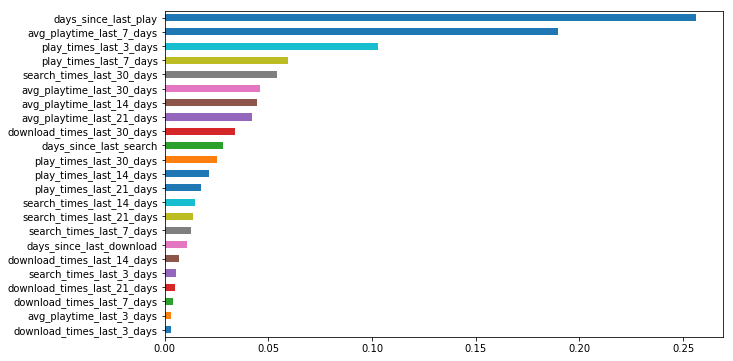

In [29]:
feature_importance = pd.Series(gbt_bestModel.featureImportances.toArray(), index=pd.Series(features)).sort_values()
fig = plt.figure(figsize = (10,6))
feature_importance.plot.barh()
#plt.xticks

* most of the most important features are still play related similar to the results from RF, download/search in the past 30 days make into the top 10 features in GBT model